<a href="https://www.kaggle.com/code/ibnarahat/hospital-patient-segmentation-system-using-k-means?scriptVersionId=237750110" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

In [2]:
# Load the data
df = pd.read_csv('/kaggle/input/hospital-data/Hospital_data_completed.csv')

In [3]:
# Data preprocessing
# Convert categorical variables to numerical
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df['Insurance_Type'] = df['Insurance_Type'].map({'None': 0, 'Private': 1, 'Public': 2})
blood_type_mapping = {'A+': 0, 'A-': 1, 'B+': 2, 'B-': 3, 'AB+': 4, 'AB-': 5, 'O+': 6, 'O-': 7}
df['Blood_Type'] = df['Blood_Type'].map(blood_type_mapping)

In [4]:
# Select features for clustering
features = ['Age', 'Gender', 'Blood_Type', 'Chronic_Condition', 'BMI', 
            'Annual_Visits', 'Avg_Stay_Duration', 'Total_Spending', 'Insurance_Type']
X = df[features]

In [5]:
# Handle missing values if any
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [6]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

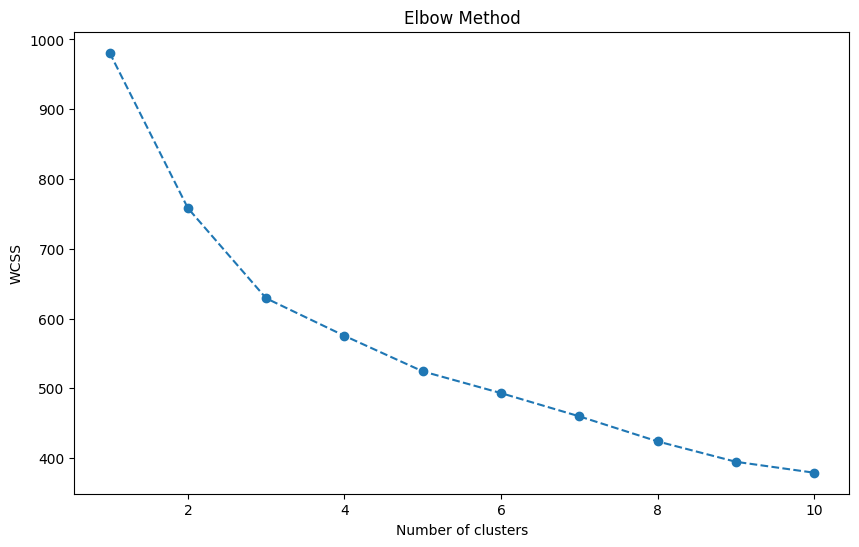

In [7]:
# Determine optimal number of clusters using Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)  # Explicit n_init
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [8]:
# Based on the elbow method, let's choose 4 clusters
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

In [9]:
# Add cluster labels to the dataframe
df['Cluster'] = clusters

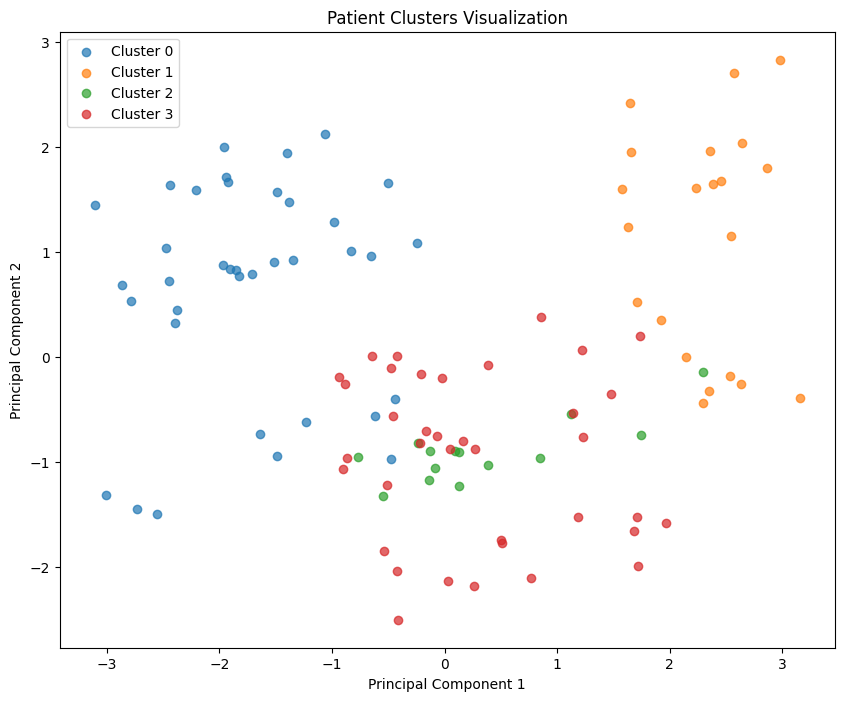

In [10]:
# Visualize clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
principal_df['Cluster'] = clusters

plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    plt.scatter(principal_df[principal_df['Cluster'] == i]['PC1'],
                principal_df[principal_df['Cluster'] == i]['PC2'],
                label=f'Cluster {i}', alpha=0.7)
plt.title('Patient Clusters Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [11]:
# Analyze cluster characteristics
cluster_profiles = df.groupby('Cluster').mean(numeric_only=True)  # Added numeric_only
print(cluster_profiles)

               Age    Gender  Blood_Type  Chronic_Condition        BMI  \
Cluster                                                                  
0        37.702703  0.000000    2.675676           0.972973  37.940541   
1        60.000000  0.142857    2.761905           1.142857  41.574286   
2        43.928571  1.000000    7.000000           0.000000  40.486429   
3        44.189189  1.000000    3.378378           2.378378  38.268649   

         Annual_Visits  Avg_Stay_Duration  Total_Spending  Insurance_Type  
Cluster                                                                    
0             4.000000           1.513514      882.108108        1.520000  
1             4.285714           6.714286     1972.885714        1.714286  
2             4.000000           3.928571     1390.578571        1.444444  
3             3.783784           3.945946     1361.064865        1.375000  


In [12]:
# Create a function to interpret clusters
def interpret_clusters(cluster_profiles):
    interpretations = []
    
    for cluster in cluster_profiles.index:
        profile = cluster_profiles.loc[cluster]
        interpretation = f"Cluster {cluster}: "
        
        # Age interpretation
        if profile['Age'] < 35:
            interpretation += "Young patients (under 35), "
        elif profile['Age'] < 50:
            interpretation += "Middle-aged patients (35-50), "
        else:
            interpretation += "Older patients (50+), "
            
        # Health condition interpretation
        if profile['Chronic_Condition'] < 1:
            interpretation += "generally healthy, "
        elif profile['Chronic_Condition'] < 2:
            interpretation += "some chronic conditions, "
        else:
            interpretation += "multiple chronic conditions, "
            
            # Utilization interpretation
        if profile['Annual_Visits'] < 3:
            interpretation += "low hospital utilization, "
        elif profile['Annual_Visits'] < 6:
            interpretation += "moderate hospital utilization, "
        else:
            interpretation += "high hospital utilization, "
            
            # Spending interpretation
        if profile['Total_Spending'] < 1000:
            interpretation += "low spending."
        elif profile['Total_Spending'] < 1500:
            interpretation += "moderate spending."
        else:
            interpretation += "high spending."
        
        interpretations.append(interpretation)
    
    return interpretations

In [13]:
# Print cluster interpretations
for interpretation in interpret_clusters(cluster_profiles):
    print(interpretation)

Cluster 0: Middle-aged patients (35-50), generally healthy, moderate hospital utilization, low spending.
Cluster 1: Older patients (50+), some chronic conditions, moderate hospital utilization, high spending.
Cluster 2: Middle-aged patients (35-50), generally healthy, moderate hospital utilization, moderate spending.
Cluster 3: Middle-aged patients (35-50), multiple chronic conditions, moderate hospital utilization, moderate spending.
